# Text Mining - Análise de Sentimentos dos Reviews da Amazon
### René Porto e Ricardo Rolim

### Importar ficheiros

In [238]:
import os
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [225]:
df = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_train.csv", encoding="utf-8")
df_test = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_test.csv", encoding="utf-8")
df.sample(5)

,sentiment,review
28323,positive,I have been eating Josephs's cookies for many ...
15908,positive,Our extended family goes through a lot of tea ...
34743,positive,My 8 year old female Beagle has always had off...
11943,negative,Item came promptly however the crisps were 3 m...
28840,positive,These make a great and tasty treat and only 50...


### Funções

In [226]:
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44

def remover_tag_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [227]:
def plot_Cloud(wordCloud, name):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    name = name + ".png"
    plt.savefig(name, facecolor='k', bbox_inches='tight')

In [228]:
def stemming(tokens):
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

In [229]:
def create_bag_Word_Corpus(df, column_name):
    words_corpus = []
    for val in df[column_name]:
        text = remover_tag_html(val)
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        words_corpus.append(tokens)
    return words_corpus

In [230]:
def summary_dataset(df, df_test):
    count_pos_train = df.loc[df.sentiment=='positive', 'sentiment'].count()
    count_neg_train = df.loc[df.sentiment=='negative', 'sentiment'].count()
    count_pos_test = df_test.loc[df_test.sentiment=='positive', 'sentiment'].count()
    count_neg_test = df_test.loc[df_test.sentiment=='negative', 'sentiment'].count()
    total_train = len(df)
    total_test = len(df_test)
    total = total_train + total_test
    print(f"Treino (positivo): {count_pos_train} - {round(100 * count_pos_train / total_train,2)}% \
          \nTreino (negativo): {count_neg_train} - {round(100 * count_neg_train / total_train,2)}% \
          \nTotal Treino: {total_train} - {round(100 * total_train / total,2)}% \
          \n \
          \nTeste (positivo): {count_pos_test} - {round(100 * count_pos_test / total_test,2)}% \
          \nTeste (negativo): {count_neg_test} - {round(100 * count_neg_test / total_test,2)}% \
          \nTotal Teste: {total_test} - {round(100 * total_test / total,2)}% \
          \n \
          \nTotal: {total}")

In [231]:
#https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe
#https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html

# Decidimos usar o ZERO como review positivo

def sentiment_calc(text):
    try:
        sentiment_binary = 'negative' if TextBlob(text).sentiment.polarity < 0 else 'positive'
        return sentiment_binary
    except:
        return None

In [351]:
def sentiment_lex(df, column, blindneg):
    sentiment_lex = []
    for x in df[column]:
        result = ''
        sentiment_score = sum(lex[i] for i in x if i in lex)
        result = 'positive' if sentiment_score >= 0 else 'negative'
        if blindneg is True:
            #result = 'negative' if any(elem in x for elem in ["not", "n't"])
            if any(elem in x for elem in ["not", "n't"]):
                result = 'negative'
        sentiment_lex.append(result)
    return sentiment_lex

In [303]:
#https://medium.com/analytics-vidhya/sentiment-analysis-movies-reviews-b299de4bb1aa
def plot_confusion_matrix_accurancy(col_pred, col_actual):
    cm = confusion_matrix(df[col_pred], df[col_actual], labels=['positive', 'negative'])
    
    plt.figure(figsize = (5,5))
    sns.heatmap(cm,cmap= "Blues", 
                linecolor = 'black', 
                linewidth = 1, 
                annot = True, 
                fmt='', 
                xticklabels = ['Negative','Positive'], 
                yticklabels = ['Negative','Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    score = accuracy_score(df[col_pred], df[col_actual])
    return print("accuracy:   %0.3f" % score)

### Análise Exploratória dos Dados

In [232]:
print(f"Valores de treino duplicados: {df.duplicated().sum()} ")
print(f"Valores de teste duplicados: {df_test.duplicated().sum()} ")

Valores de treino duplicados: 3531 
Valores de teste duplicados: 25 


In [233]:
summary_dataset(df, df_test)

Treino (positivo): 37835 - 77.37%           
Treino (negativo): 11067 - 22.63%           
Total Treino: 48902 - 95.29%           
           
Teste (positivo): 1676 - 69.34%           
Teste (negativo): 741 - 30.66%           
Total Teste: 2417 - 4.71%           
           
Total: 51319


In [234]:
df = df.drop_duplicates()
df_test = df_test.drop_duplicates()
summary_dataset(df, df_test)

Treino (positivo): 35363 - 77.94%           
Treino (negativo): 10008 - 22.06%           
Total Treino: 45371 - 94.99%           
           
Teste (positivo): 1667 - 69.69%           
Teste (negativo): 725 - 30.31%           
Total Teste: 2392 - 5.01%           
           
Total: 47763


Foram encontrados registos duplicados, como a proporção entre os reviews positivos e negativos não se alteraram, decidimos então remover os registos duplicados

### Baseline

In [235]:
df['sentiment_calculated'] = df['review'].apply(sentiment_calc)

In [236]:
df.sample(10)

,sentiment,review,sentiment_calculated
32367,positive,This is a quality tea that requires you to fol...,positive
48326,positive,Not a bad sauce but there does seem to be some...,positive
21451,positive,I would definitely reccomend these for your do...,positive
41731,positive,An Italian acquaintance (from Milan) swears by...,positive
9046,positive,UPDATE June 2009: They changed the recipe so t...,negative
18199,positive,This food contains all of the good stuff and n...,positive
35776,negative,Beacuse of terrible packaging the plastic bags...,negative
38136,positive,The other Greenies flavors are ok. Other cat ...,positive
14284,positive,This is my dogs favorite toy. I got this last ...,positive
45778,positive,This is a powder drink mix that you can add to...,negative


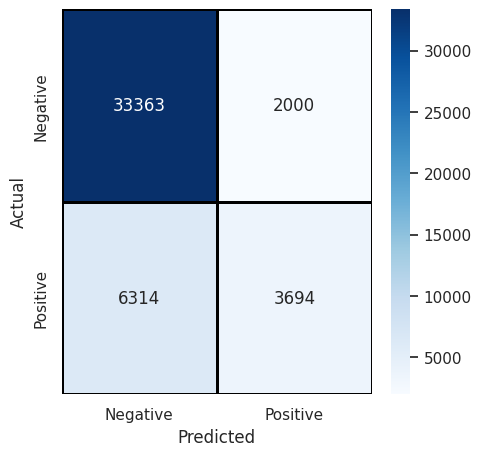

accuracy:   0.817


In [302]:
plot_confusion_matrix_accurancy('sentiment', 'sentiment_calculated')

### Aplicação de um léxico de sentimentos

In [272]:
lex = pd.read_csv("../TM/data/en/NCR-lexicon.csv", encoding="utf-8")
lex.set_index("English", inplace=True)
lex = lex['Positive'] - lex['Negative']
lex = lex.to_dict()

In [273]:
df['bag'] = create_bag_Word_Corpus(df, 'review')

#### Sem tratamento da negação

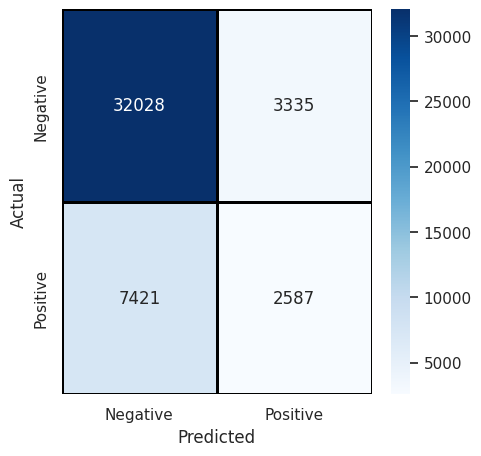

accuracy:   0.763


In [349]:
df['sentiment_lex'] = sentiment_lex(df, 'bag', blindneg=False)
plot_confusion_matrix_accurancy('sentiment', 'sentiment_lex')

#### Com tratamento da negação

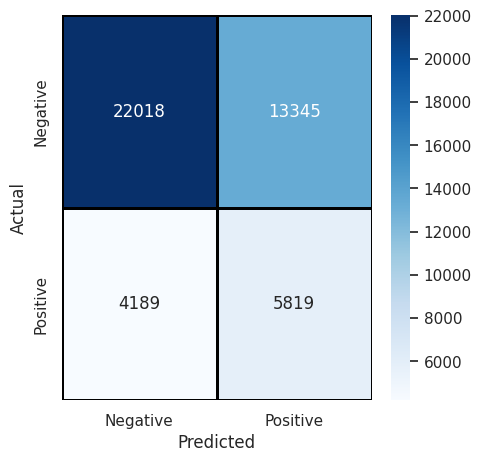

accuracy:   0.614


In [350]:
df['sentiment_lex_bn'] = sentiment_lex(df, 'bag', blindneg=True)
plot_confusion_matrix_accurancy('sentiment', 'sentiment_lex_bn')